# Node-centric expression models (NCEM)

### Preprint: [Learning cell communication from spatial graphs of cells](https://www.biorxiv.org/content/10.1101/2021.07.11.451750v1) (Fischer, Schaar, Theis, 2021)

![title](https://raw.githubusercontent.com/theislab/ncem/main/docs/_static/img/concept.png)

#### Spatial graphs of single cells

* Typically derived from segmentation on spatial omics assays with sub cellular resolution (IMC, MERFISH, seqFISH, CODEX, …)

* Describe “niches”: spatial arrangements of sets of cells that are often characteristic of tissues.
    * Niches approximate emergent phenomena in tissues that are not clear from dissociated cells. [Schürch, C. M. et al., Cell 183, 838 (2020).]
   
&nbsp;
    

#### Node-centric expression models (NCEM)

* relate niche composition on the level of cell type to the cell-wise gene expression states.
    * This explains within-cell type gene expression variation.
 
* Type-type dependencies can be encoded in parameters.

##### $\Rightarrow$ NCEM are graph neural networks

&nbsp;

#### Cell–cell dependencies may be caused by: 

* ligand-receptor-based communication between cells
* physical interactions
* membrane junctions
* metabolite exchange

Therefore, we consider the effects of niche composition on all genes, rather than on receptor signaling genes only.



## Import packages

In [12]:
%load_ext autoreload
%autoreload 2

import ncem
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Loading the data with the predefined data loader

In [13]:
# data path
path = '/home/abdul-muqeeth/Desktop/ncem/ncem_tutorials/tutorials'

In [14]:
interpreter = ncem.interpretation.interpreter.InterpreterInteraction()
interpreter.get_data(
    data_origin='hartmann',
    data_path=path + '/data/hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 18.23it/s]

Loaded 58 images with complete data from 4 patients over 63747 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416036

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


0.0
1.000547499859607
10.193272571484671
128.1181909355233
1071.8057746883462


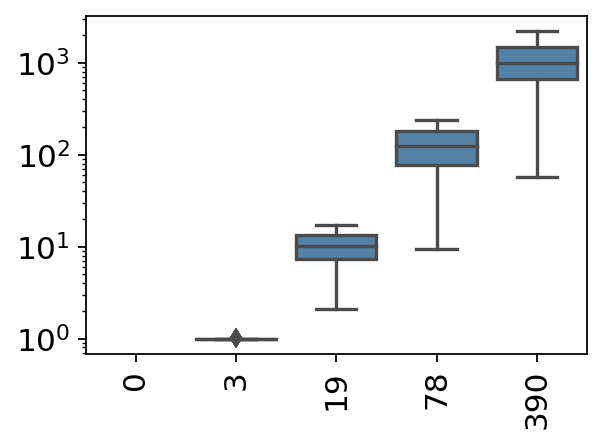

In [15]:
# node degrees for different radii
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024,
)

# 1. Grid searches over neighbourhood sizes

In [16]:
gs = ncem.train.GridSearchContainer(
    path + '/grid_searches_gen/', 
    gs_ids=[
        "210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN",
        "210419_INTERACTIONS_MAX_NODES_IMAGE_1_HARTMANN",
    ],
    lateral_resolution = 400/1024
)
gs.load_gs()

gs.plot_best_model_by_hyperparam(
    graph_model_class='interactions',
    baseline_model_class='interactions_baseline',
    rename_levels = [
        ("model", {
            "INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1": "baseline",
            "INTERACTIONS_MAX_NODES_IMAGE_1": "NCEM",
        })
    ],
    xticks=[0, 10, 50, 200, 1000],
)

  0%|                                                                   | 0/2 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/abdul-muqeeth/Desktop/ncem/ncem_tutorials/tutorials/grid_searches_gen/210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN/results/'

## Length scales of dependencies for different target cell-types.

In [17]:
gs.load_target_cell_evaluation()
gs.plot_target_cell_evaluation(
    metric_show="r_squared_linreg",
    metric_select="r_squared_linreg",
    param_x="um_radius",
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/abdul-muqeeth/Desktop/ncem/ncem_tutorials/tutorials/grid_searches_gen/210419_INTERACTIONS_BASELINE_NONE_NODES_IMAGE_1_HARTMANN/results/'

# 2. Extracting sender-receiver effects with NCEM

In [16]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 10
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())

Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 63747 cells out of 58 images from 4 patients.
Test dataset: 6376 cells out of 58 images from 4 patients.
Training dataset: 51914 cells out of 58 images from 4 patients.
Validation dataset: 5738 cells out of 58 images from 4 patients. 



In [25]:
interpreter.get_sender_receiver_effects()

100%|████████████████████████████████████████████████████▊| 6351/6374 [02:45<00:00, 38.37it/s]


using ols parameters.
(63510, 8)
(63510, 64)
X shape: (72, 63510)
y_ shape: (63510, 36)
calculating inv fim.


# Type coupling analysis

Heatmap color is proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. 

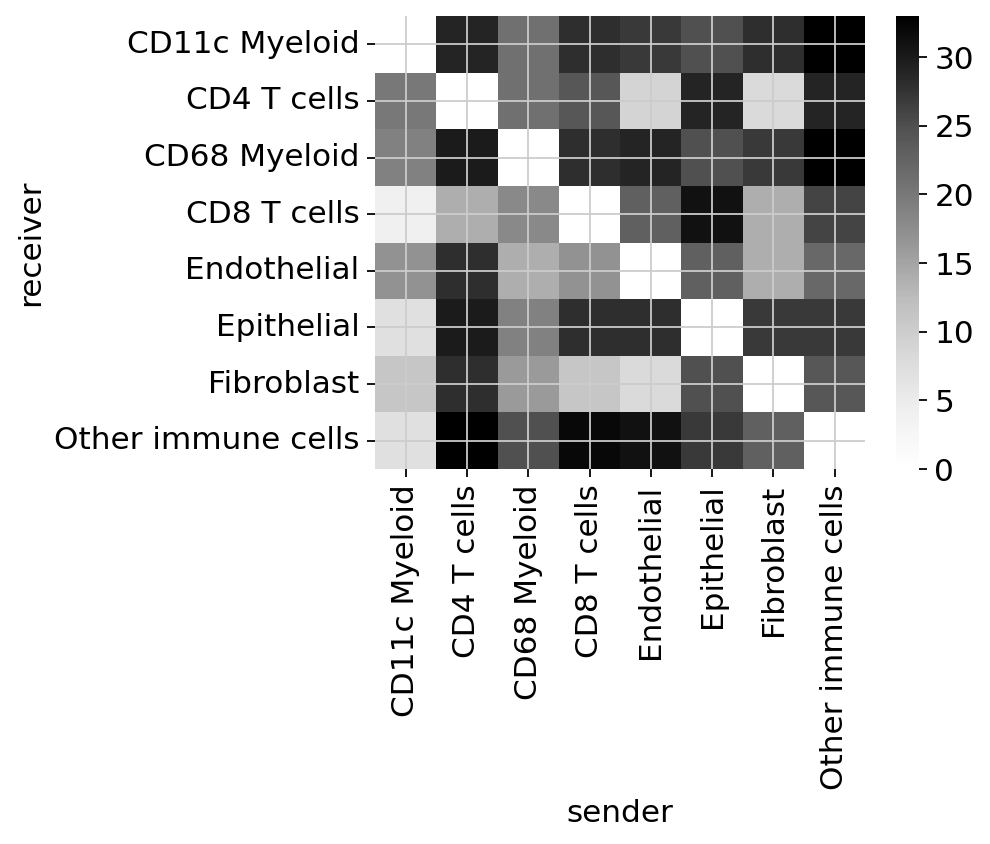

In [26]:
interpreter.type_coupling_analysis(figsize=(6.5, 5.5))

Edge width proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. Only edges with eat least 24 differentially expressed genes are shown.


**Arrow thickness:** strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector

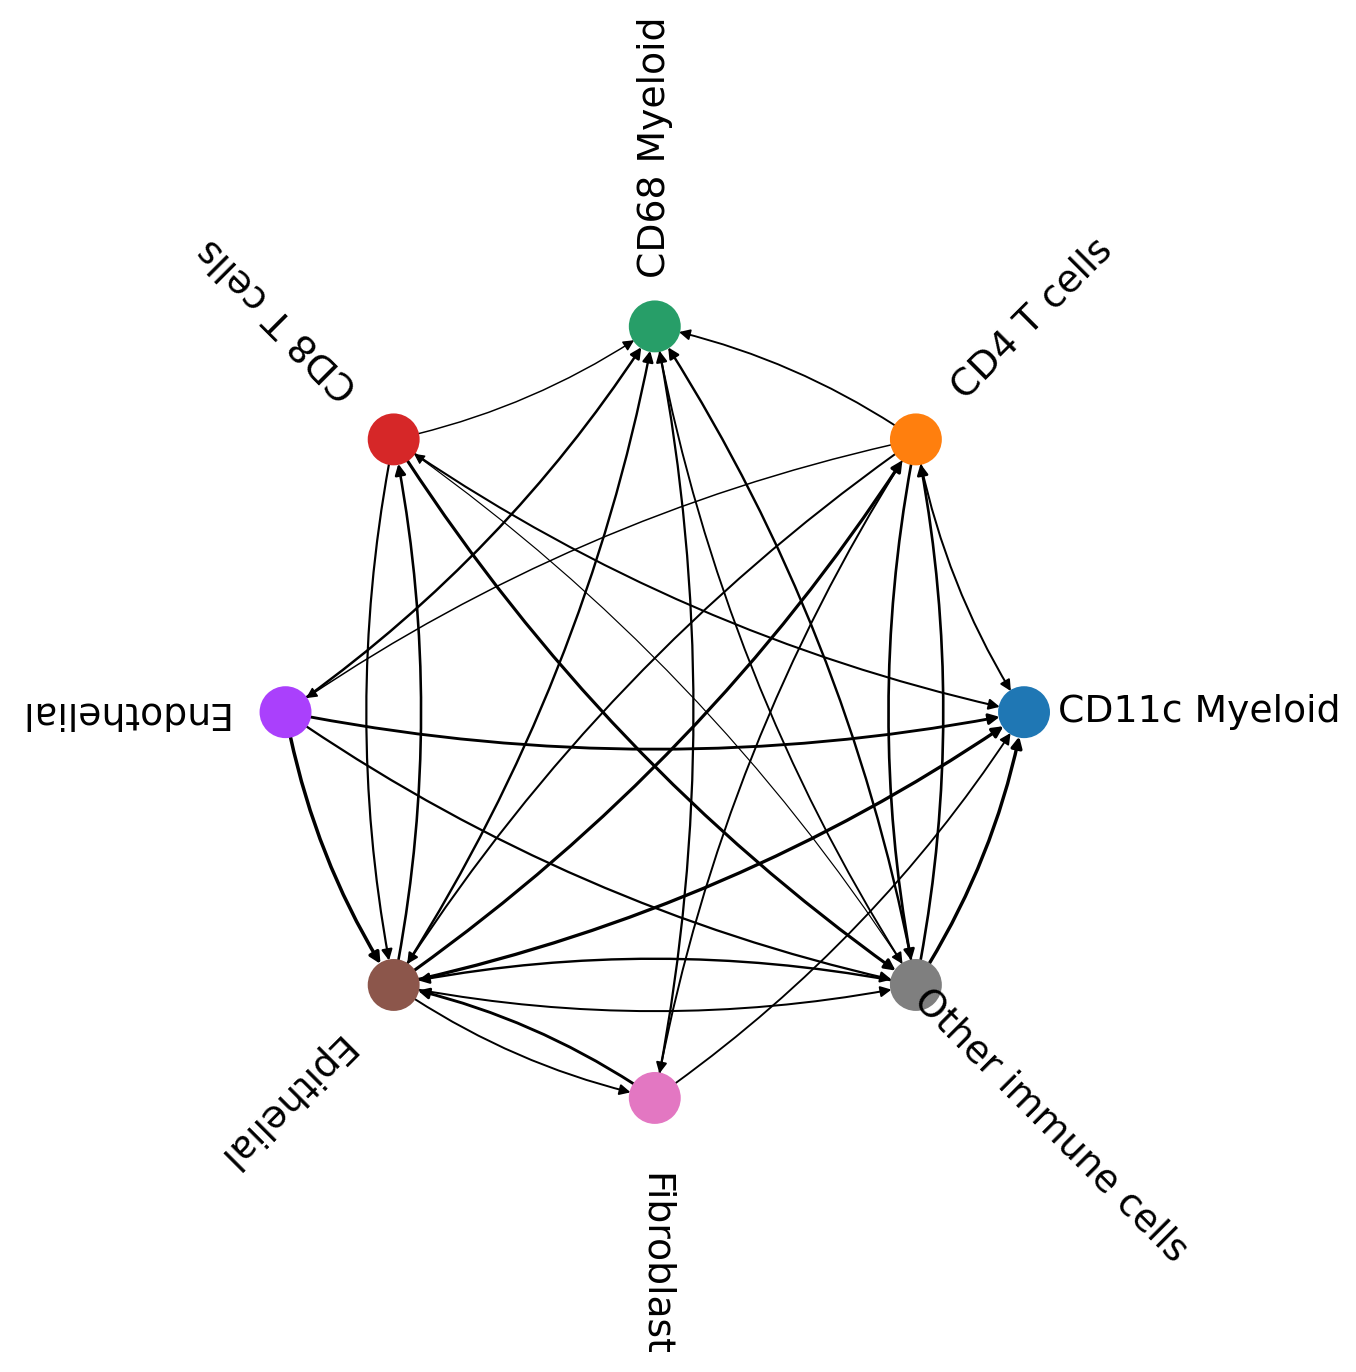

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,CD11c Myeloid,CD4 T cells,20,0.184583,0.551724,20
2,CD11c Myeloid,CD68 Myeloid,19,0.180837,0.517241,19
3,CD11c Myeloid,CD8 T cells,4,0.059416,0.000000,4
4,CD11c Myeloid,Endothelial,17,0.201234,0.448276,17
5,CD11c Myeloid,Epithelial,7,0.183564,0.103448,7
6,CD11c Myeloid,Fibroblast,11,0.187391,0.241379,11
7,CD11c Myeloid,Other immune cells,7,0.201477,0.103448,7
8,CD4 T cells,CD11c Myeloid,29,0.258742,0.862069,29
10,CD4 T cells,CD68 Myeloid,30,0.241639,0.896552,30
11,CD4 T cells,CD8 T cells,14,0.066372,0.344828,14


In [27]:
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

# 3. Directional sender effects for Epithelial cells and CD8 T cells

We dissected these couplings based on the gene-wise effects of all senders on one receiver type for CD8T cells and Epithelial cells which contextualizes differential expression results of the CD8T cell–Epithelial cell axis.

NCEM correctly identifies genes and proteins that play roles in T-cell activation, regulation of T-cell antigen receptor signalling and immune response.

## a) Sender effects on CD8 T cells 

“Sender effect” analysis heatmap for CD8 T cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving CD8 T cells.

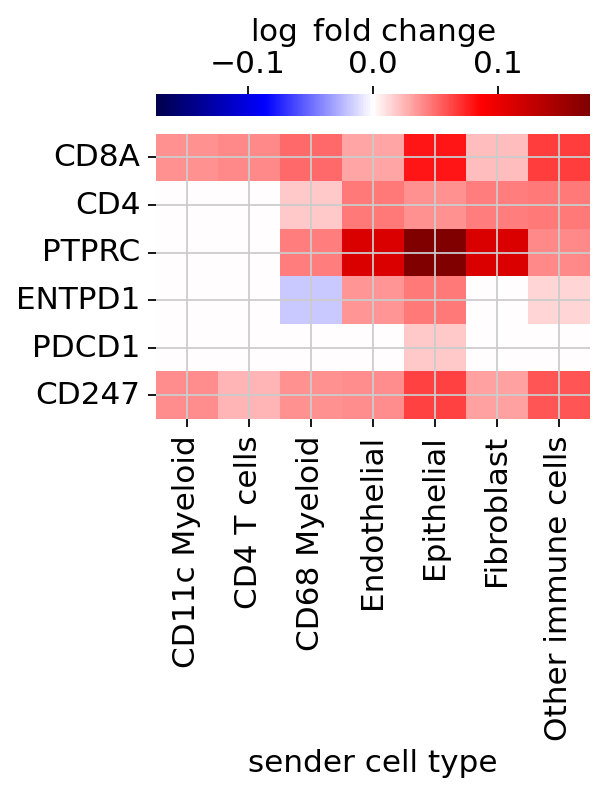

In [28]:
interpreter.sender_effect(
    receiver='CD8 T cells', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

## b) Sender effects on Epithelial cells

“Sender effect” analysis heatmap for Epithelial cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving Epithelial cells.

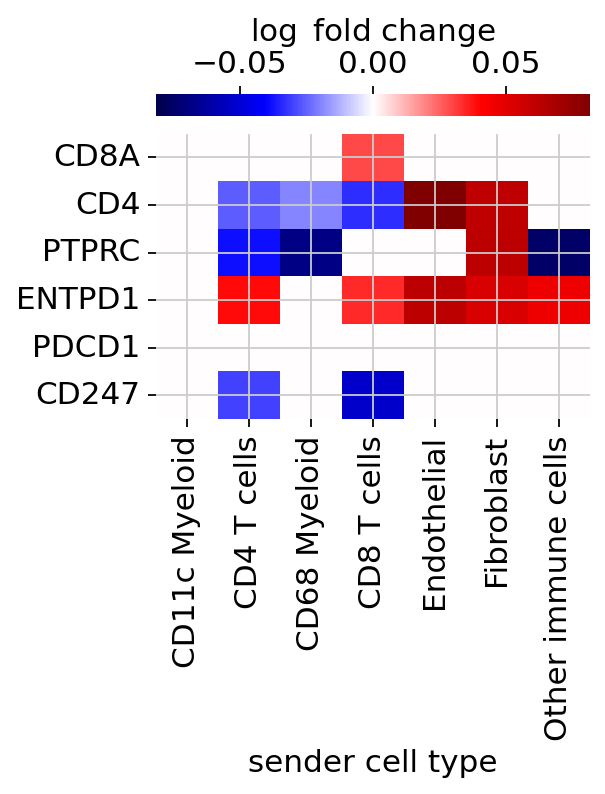

In [29]:
interpreter.sender_effect(
    receiver='Epithelial', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

## c) Directional effect for sender-receiver axis for CD8 T cells on Epithelial cells 

This analysis contextualizes differential expression results of the CD8 Tcell – Epithelial cell axis.

Volcano plot of differentially expressed genes of Epithelial cells in the neighborhood of CD8 T cells.

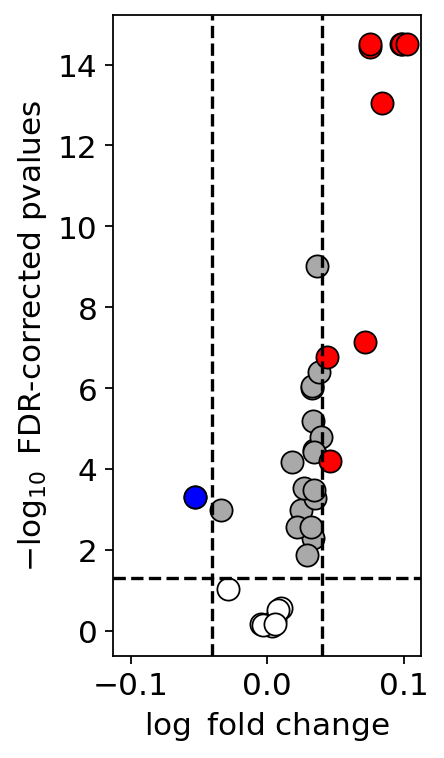

In [30]:
interpreter.sender_receiver_effect_vulcanoplot(
    sender='CD8 T cells', 
    receiver='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

In [31]:
# low fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change').head(5)

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
CD247,0.033484,0.000222,0.000502,-0.052485,3.299011
CD4,0.443923,0.000481,0.001045,-0.033690,2.980705
PTPRC,0.092476,0.058306,0.090830,-0.028594,1.041769
PECAM1,0.019289,0.596243,0.670774,-0.004426,0.173424
LDHA,0.631155,0.640090,0.706134,-0.003231,0.151113


In [32]:
# high fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change', ascending=False).head(5)

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
ATP1A1,0.601787,0.000000e+00,0.000000e+00,0.102429,inf
SLC1A5,0.617982,0.000000e+00,0.000000e+00,0.098478,inf
SLC3A2,0.458504,0.000000e+00,0.000000e+00,0.098254,inf
CKM,0.491796,1.842970e-14,9.034475e-14,0.084243,13.044097
CDH1,0.538660,6.661338e-16,3.636901e-15,0.075619,14.439268


## d) Squidpy: Ligand-receptor interactions

Again, these core associations are reproduced by CellphoneDB. However only on  receptor signaling genes. The shown result can be extracted with Squidpy. 

NCEM is not limited to receptor signaling genes only.

In [33]:
adata = interpreter.data.ligrec(
    fraction=0.70,
)

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

n cells: 44622


KeyError: 'Cluster key `Cluster_preprocessed` not found in `adata.obs`.'

# 4. Sender similarity analysis for Epithelial cells

“Sender similarity analysis” of all sender cell types with respect to Epithelial cell receivers. Shown is a clustered heatmap of Pearson correlation coefficients of the coefficient vectors of each sender type that corresponds to Epithelial cell receivers.

T cell clusters and other immune cells had a similar effect on Epithelial cells in a “sender similarity analysis”, in which we correlated the coefficient vectors of sender cell types that correspond to Epithelial cell receivers, which demonstrates conservation of cell type identity in the sender profile.

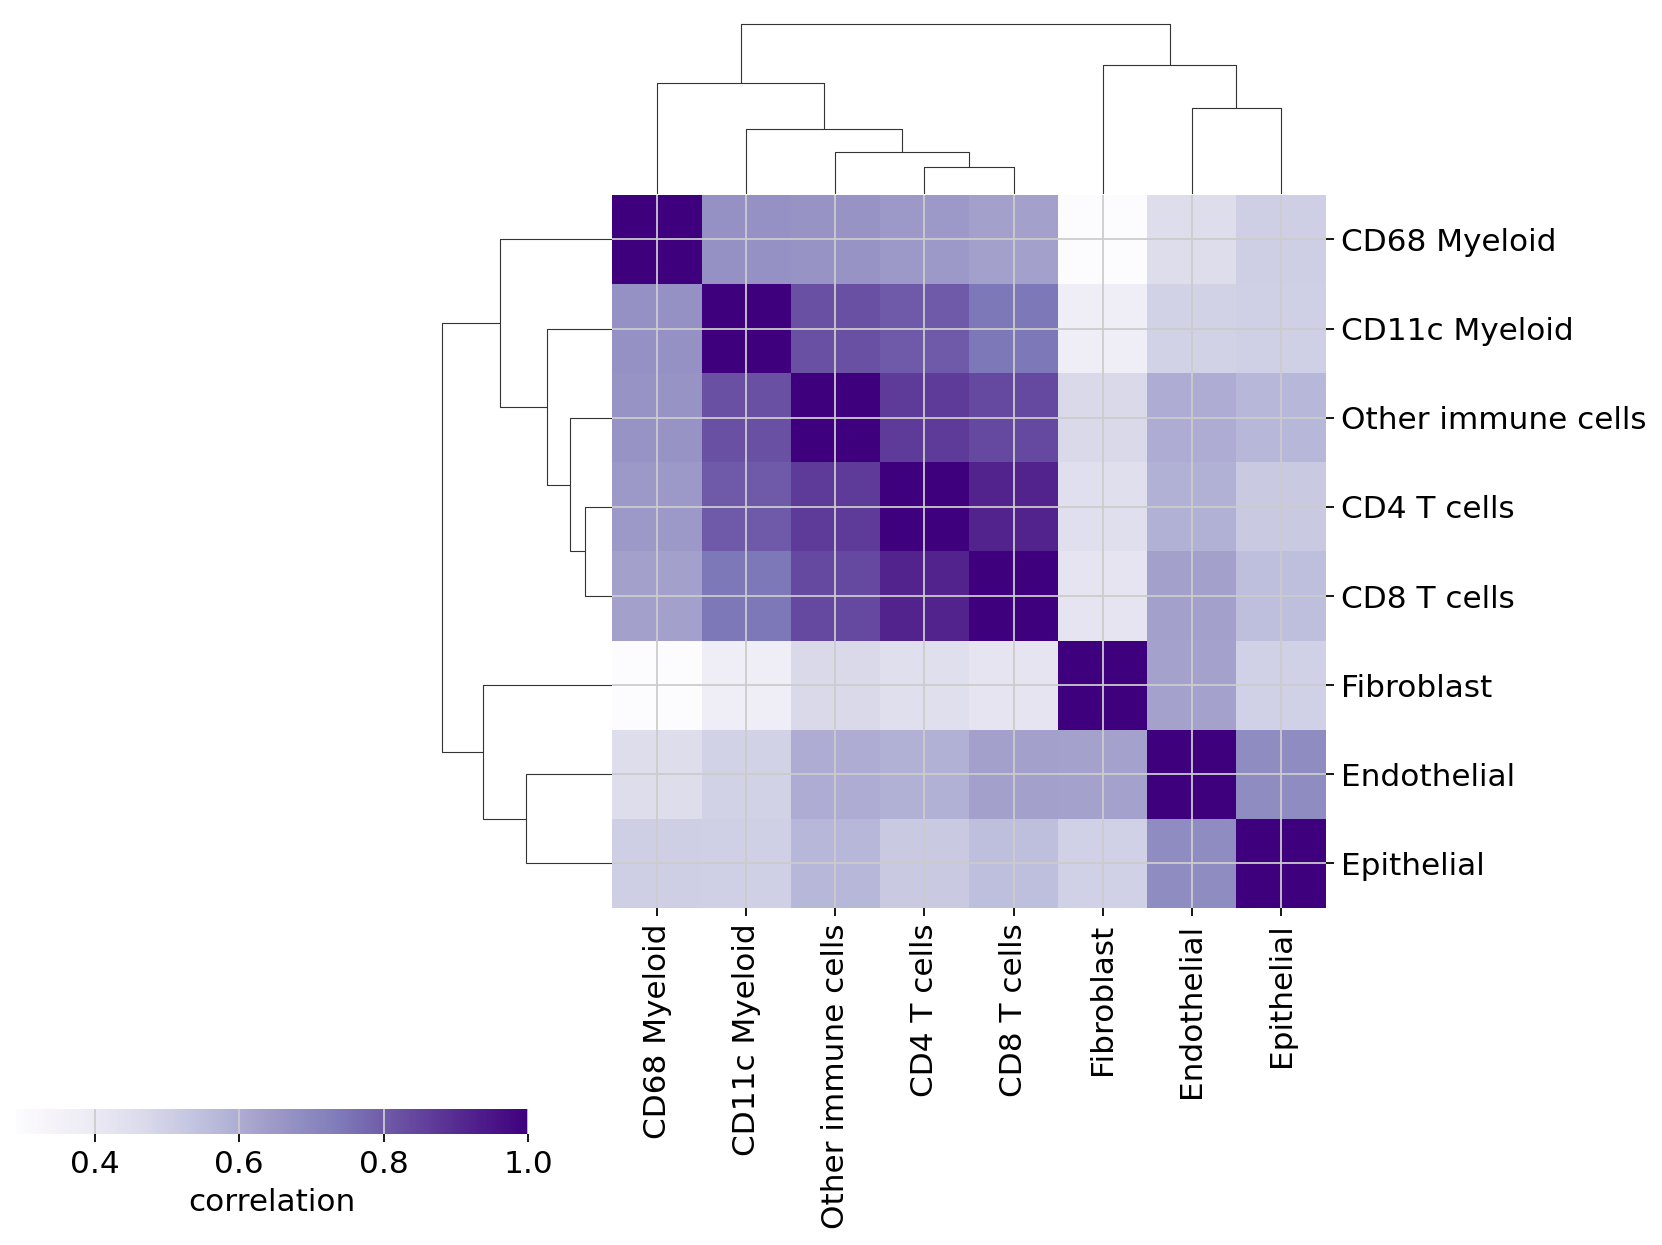

In [34]:
interpreter.sender_similarity_analysis(receiver='Epithelial')

# 5. Outlook & Announcements

* Custom dataloader functions available soon. (beta version) 

* SCOG workshop on spatial omics analysis. 